In [0]:
%pip install vaderSentiment

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import pandas as pd
from pyspark.sql.functions import to_timestamp, col, regexp_replace, lower, when
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import col, to_date
import matplotlib.pyplot as plt
from pyspark.sql.functions import corr
from pyspark.sql.functions import month, year, concat_ws
import numpy as np
import seaborn as sns
import requests
from datetime import datetime


In [0]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv

--2025-03-29 15:24:11--  https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 3.5.206.24, 52.95.156.32
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|3.5.206.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24708828 (24M) [text/csv]
Saving to: ‘bitcoin_tweets.csv.1’

bitcoin_tweets.csv. 100%[===================>]  23.56M  12.3MB/s    in 1.9s    

2025-03-29 15:24:14 (12.3 MB/s) - ‘bitcoin_tweets.csv.1’ saved [24708828/24708828]



In [0]:
dataset = pd.read_csv('/databricks/driver/bitcoin_tweets.csv', delimiter=",")

# Creazione del dataframe Spark
spark_df = spark.createDataFrame(dataset)

# Visualizzazione delle prime righe del dataframe
spark_df.show(5)

# Rimozione di eventuali righe con valori nulli
spark_df_cleaned = spark_df.dropna()

# Rimozione di duplicati
spark_df_cleaned = spark_df_cleaned.dropDuplicates()

# Verifica della pulizia
spark_df_cleaned.count(), spark_df_cleaned.columns

+--------------------+-------------+-------------------+----+--------------------+-------+-----+--------+--------------------+
|                  id|         user|           fullname| url|           timestamp|replies|likes|retweets|                text|
+--------------------+-------------+-------------------+----+--------------------+-------+-----+--------+--------------------+
|1.132977055300300...| KamdemAbdiel|      Abdiel kamdem|null|2019-05-27 11:49:...|    0.0|  0.0|     0.0|È appena uscito u...|
|1.132977073402736...|    bitcointe|          Bitcointe|null|2019-05-27 11:49:...|    0.0|  0.0|     0.0|Cardano: Digitize...|
|1.132977023893139...|    3eyedbran|Bran - 3 Eyed Raven|null|2019-05-27 11:49:...|    0.0|  2.0|     1.0|Another Test twee...|
|1.132977089089556...|DetroitCrypto|        J. Scardina|null|2019-05-27 11:49:...|    0.0|  0.0|     0.0|Current Crypto Pr...|
|1.132977092340191...| mmursaleen72| Muhammad Mursaleen|null|2019-05-27 11:49:...|    0.0|  0.0|     0.0|Spiv (

In [0]:
# Rimozione delle colonne inutili
spark_df = spark_df.drop("fullname", "url")

# Conversione della colonna timestamp
spark_df = spark_df.withColumn("timestamp", to_timestamp("timestamp"))

# Pre-elaborazione del testo (pulizia): rimuovi URL, menzioni, simboli speciali
spark_df = spark_df.withColumn("cleaned_text", regexp_replace(col("text"), r"http\S+|www.\S+|@\w+|[^a-zA-Z\s]", ""))
spark_df = spark_df.withColumn("cleaned_text", lower(col("cleaned_text")))

spark_df.dropDuplicates() 
spark_df = spark_df.filter(spark_df["timestamp"].isNotNull()) 

# Filtraggio  delle righe con valori non nulli in cleaned_text
spark_df = spark_df.filter(col("cleaned_text").isNotNull())
# Sostituzione dei valori nulli o None con stringa vuota
spark_df = spark_df.fillna({'cleaned_text': ''})
# Conteggio dei valori nulli dopo la pulizia
null_count = spark_df.filter(col("cleaned_text").isNull()).count()
print(f"Righe con valori nulli in cleaned_text dopo la pulizia: {null_count}")

# Esplorazione delle modifiche
spark_df.show(5)

Righe con valori nulli in cleaned_text dopo la pulizia: 0
+--------------------+-------------+-------------------+-------+-----+--------+--------------------+--------------------+
|                  id|         user|          timestamp|replies|likes|retweets|                text|        cleaned_text|
+--------------------+-------------+-------------------+-------+-----+--------+--------------------+--------------------+
|1.132977055300300...| KamdemAbdiel|2019-05-27 11:49:14|    0.0|  0.0|     0.0|È appena uscito u...| appena uscito un...|
|1.132977073402736...|    bitcointe|2019-05-27 11:49:18|    0.0|  0.0|     0.0|Cardano: Digitize...|cardano digitize ...|
|1.132977023893139...|    3eyedbran|2019-05-27 11:49:06|    0.0|  2.0|     1.0|Another Test twee...|another test twee...|
|1.132977089089556...|DetroitCrypto|2019-05-27 11:49:22|    0.0|  0.0|     0.0|Current Crypto Pr...|current crypto pr...|
|1.132977092340191...| mmursaleen72|2019-05-27 11:49:23|    0.0|  0.0|     0.0|Spiv (Nos

In [0]:

# Inizializzazione dell'analizzatore di sentiment
analyzer = SentimentIntensityAnalyzer()

# Funzione di sentiment analysis
def sentiment_analysis(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Creazione di una UDF per Spark
sentiment_udf = udf(sentiment_analysis, StringType())

# Applicazione della funzione di sentiment analysis
spark_df_cleaned = spark_df_cleaned.withColumn('sentiment', sentiment_udf(spark_df_cleaned['text']))

# Verifica del risultato
spark_df_cleaned.select('text', 'sentiment').show(5)

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|USD: 109.930\nEUR...|  Neutral|
|May 09, 2019 00:1...|  Neutral|
|#Bitcoin $6,109.7...|  Neutral|
|QNO #Vaultmex Pri...| Positive|
|1 BTC = 23855.686...|  Neutral|
+--------------------+---------+
only showing top 5 rows



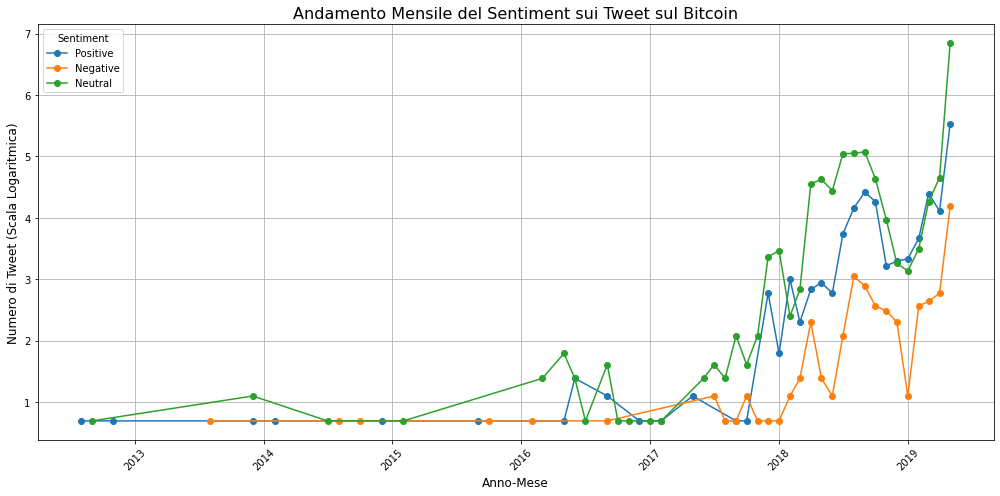

In [0]:

# Creazione della colonna 'year_month' nel formato 'YYYY-MM'
spark_df_cleaned = spark_df_cleaned.withColumn('year_month', 
                                               concat_ws('-', year(spark_df_cleaned['timestamp']), 
                                                         month(spark_df_cleaned['timestamp'])))

# Aggregazione dei tweet per 'year_month' e 'sentiment'
sentiment_monthly = spark_df_cleaned.groupBy('year_month', 'sentiment').count().orderBy('year_month')

# Conversione in Pandas per la visualizzazione
sentiment_monthly_pd = sentiment_monthly.toPandas()

# Ordinare i dati per 'year_month'
sentiment_monthly_pd['year_month'] = pd.to_datetime(sentiment_monthly_pd['year_month'], format='%Y-%m')  # Converte la stringa in datetime
sentiment_monthly_pd = sentiment_monthly_pd.sort_values('year_month')  # Ordinamento crescente

# Applicazione della trasformazione logaritmica sul numero di tweet (count)
sentiment_monthly_pd["count"] = np.log1p(sentiment_monthly_pd["count"])

# Creazione del grafico
plt.figure(figsize=(14, 7))

# Loop per tracciare i dati per ciascun sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    sentiment_data = sentiment_monthly_pd[sentiment_monthly_pd['sentiment'] == sentiment].copy()
    
    # Tracciamento della linea per il sentiment
    plt.plot(sentiment_data["year_month"], sentiment_data["count"], marker="o", linestyle="-", label=sentiment)

# Personalizzazione del grafico
plt.title("Andamento Mensile del Sentiment sui Tweet sul Bitcoin", fontsize=16)
plt.xlabel("Anno-Mese", fontsize=12)
plt.ylabel("Numero di Tweet (Scala Logaritmica)", fontsize=12)
plt.legend(title="Sentiment")
plt.grid(True)
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse X per una migliore leggibilità
plt.tight_layout()

# Visualizzazione del grafico
plt.show()


Negli anni precedenti al 2015 i sentimenti erano contrastanti mentre _dal 2015_ in poi possiamo vedere una notevole crescita di **sentimenti positivi**. In generale, i bitcoin hanno risposso più successo aumentando tutti i sentiment ma possiamo affermare che la maggior parte è composta da sentiment positivi.

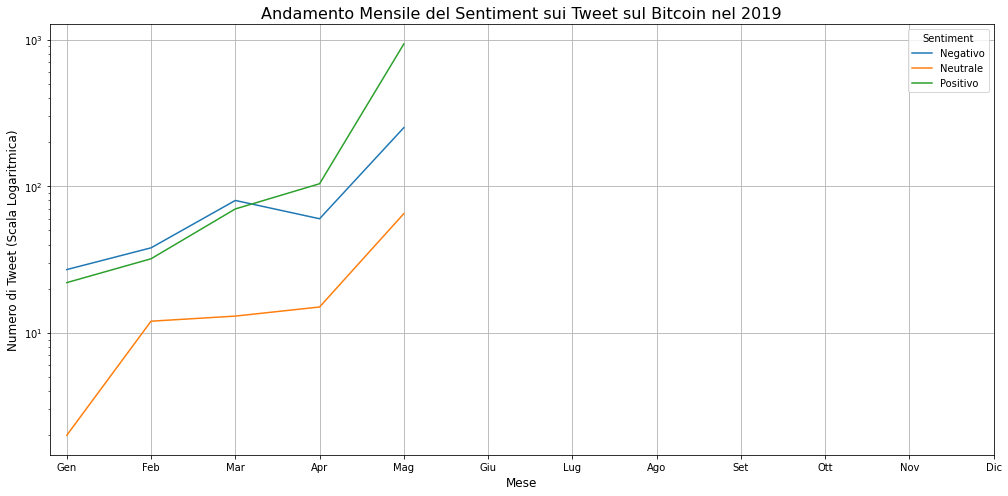

In [0]:
# Focus sull'anno 2019
# Creazione di una nuova colonna per il mese e anno
spark_df_cleaned = spark_df_cleaned.withColumn('year', year(spark_df_cleaned['timestamp']))
spark_df_cleaned = spark_df_cleaned.withColumn('month', month(spark_df_cleaned['timestamp']))

# Aggregazione del sentiment per mese, ordinato per anno e mese
sentiment_by_month = spark_df_cleaned.groupBy('year', 'month', 'sentiment').count().orderBy('year', 'month')

# Conversione in Pandas per la visualizzazione
sentiment_monthly_pd = sentiment_by_month.toPandas()
sentiment_2019_pd = sentiment_monthly_pd[sentiment_monthly_pd['year'] == 2019]

# Creazione del grafico per il 2019
plt.figure(figsize=(14, 7))
for sentiment in ['Positive', 'Negative', 'Neutral']:
    sentiment_data_2019 = sentiment_2019_pd[sentiment_2019_pd['sentiment'] == sentiment]
    plt.plot(sentiment_data_2019['month'], sentiment_data_2019['count'], label=sentiment)

plt.yscale('log')  # Scala logaritmica per il numero di tweet
plt.title("Andamento Mensile del Sentiment sui Tweet sul Bitcoin nel 2019", fontsize=16)
plt.xlabel("Mese", fontsize=12)
plt.ylabel("Numero di Tweet (Scala Logaritmica)", fontsize=12)
plt.legend(title="Sentiment", labels=["Negativo", "Neutrale", "Positivo"])
plt.grid()
plt.tight_layout()
plt.xticks(np.arange(1, 13), ['Gen', 'Feb', 'Mar', 'Apr', 'Mag', 'Giu', 'Lug', 'Ago', 'Set', 'Ott', 'Nov', 'Dic'])
plt.show()


Prendendo in considerazione l'anno più recente, vediamo che inizialmente i sentiment positivi e negativi erano molto vicini mentre negli ultimi mesi ritornano preponderanti i sentiment positivi.

<command-3998393320146071>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_mothly_2019_pd['count'] = sentiment_mothly_2019_pd['count'].apply(lambda x: min(x, 200))


<Figure size 1008x504 with 0 Axes>

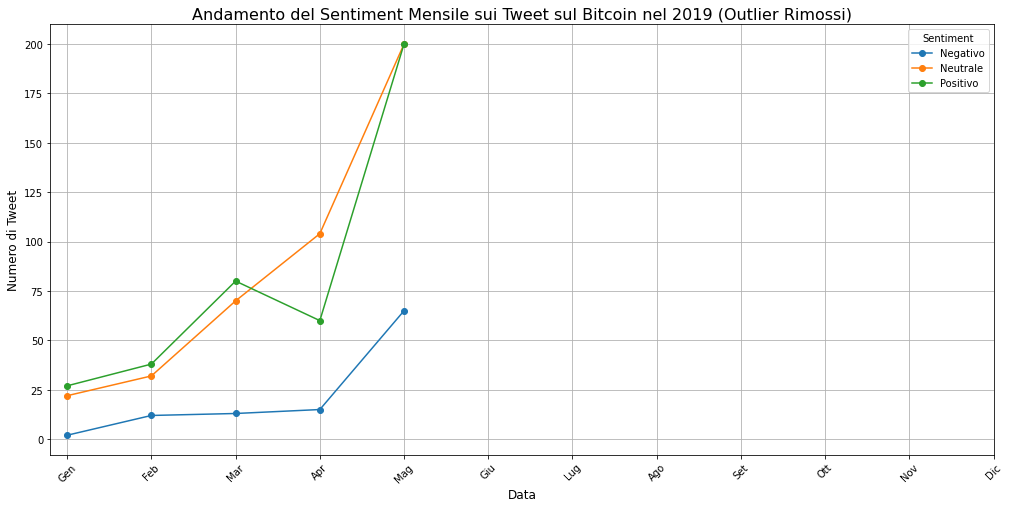

In [0]:
# Rimozione degli outlier sopra i 200 tweet per giorno
sentiment_mothly_2019_pd = sentiment_monthly_pd[sentiment_monthly_pd['year'] == 2019]
sentiment_mothly_2019_pd['count'] = sentiment_mothly_2019_pd['count'].apply(lambda x: min(x, 200))

# Creazione di una tabella pivot per l'anno 2019, con sentiment come colonne e data come indice
filtered_pivot_2019_df = sentiment_mothly_2019_pd.pivot_table(
    index='month', 
    columns='sentiment', 
    values='count', 
    aggfunc='sum', 
    fill_value=0
)

# Creazione del grafico per l'anno 2019 con outlier rimossi
plt.figure(figsize=(14, 7))
filtered_pivot_2019_df.plot(kind="line", marker="o", figsize=(14, 7))
plt.title("Andamento del Sentiment Mensile sui Tweet sul Bitcoin nel 2019 (Outlier Rimossi)", fontsize=16)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Numero di Tweet", fontsize=12)
plt.legend(title="Sentiment", labels=["Negativo", "Neutrale", "Positivo"])
plt.grid()
plt.tight_layout()
plt.xticks(rotation=45)
plt.xticks(np.arange(1, 13), ['Gen', 'Feb', 'Mar', 'Apr', 'Mag', 'Giu', 'Lug', 'Ago', 'Set', 'Ott', 'Nov', 'Dic'])
plt.show()

Per evitare dati falsati, abbiamo rimosso i giorni in cui i tweet hanno supersto i 200. Dal grafico è evidente che i bitcoin continuano a riscontare sentiment molto positivi.

In [0]:
# Calcolo della media dei like per sentiment
like_analysis = spark_df_cleaned.groupBy('sentiment').agg({'likes': 'avg'}).withColumnRenamed('avg(likes)', 'avg_likes')

like_analysis.show()


+---------+------------------+
|sentiment|         avg_likes|
+---------+------------------+
|  Neutral| 5.589133363268972|
| Positive|11.571265678449258|
| Negative| 7.806451612903226|
+---------+------------------+



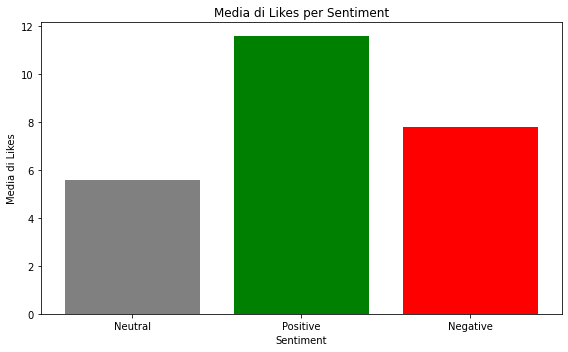

In [0]:
# Conversione in Pandas per un confronto visivo
like_analysis_pd = like_analysis.toPandas()

# Creazione di un grafico a barre

plt.figure(figsize=(8, 5))
plt.bar(like_analysis_pd["sentiment"], like_analysis_pd["avg_likes"], color=["gray","green", "red"])
plt.title("Media di Likes per Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Media di Likes")
plt.tight_layout()
plt.show()

I tweet negativi ricevono meno like dei positivi.

In [0]:
# Calcolo delle medie di risposte per i tweet negativi e positivi
replies_analysis = spark_df_cleaned.groupBy('sentiment').agg({'replies': 'avg'}).withColumnRenamed('avg(replies)', 'avg_replies')

replies_analysis.show()

+---------+------------------+
|sentiment|       avg_replies|
+---------+------------------+
|  Neutral|0.6057476425684778|
| Positive|1.5986316989737743|
| Negative|1.4792626728110598|
+---------+------------------+



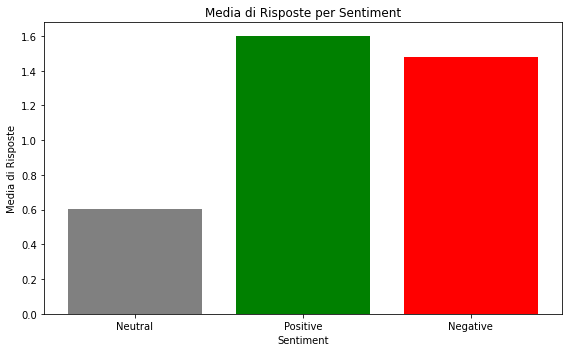

In [0]:
# Conversione in Pandas per un confronto visivo
replies_analysis_pd = replies_analysis.toPandas()

# Creazione di un grafico a barre

plt.figure(figsize=(8, 5))
plt.bar(replies_analysis_pd["sentiment"], replies_analysis_pd["avg_replies"], color=["gray","green", "red"])
plt.title("Media di Risposte per Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Media di Risposte")
plt.tight_layout()
plt.show()

I tweet negativi non ricevono più interazioni rispetto ai tweet positivi.

In [0]:
#Import dei dati sui bitcoin
api_key = '4dee791ab741d1442b0e38905264789b50384c26d846bb19a80286080eef1764'

# URL per i dati storici di Bitcoin
url = 'https://min-api.cryptocompare.com/data/v2/histoday'

# Parametri per ottenere i dati dal 1 gennaio 2019 fino alla fine del 2019
params = {
    'fsym': 'BTC',
    'tsym': 'USD',
    'limit': 2000,
    'toTs': int(datetime(2019, 12, 31).timestamp()),
    'api_key': api_key,
}

response = requests.get(url, params=params)
data = response.json()

# Estrazione dei dati dei prezzi
prices = data['Data']['Data']

# Creazione di un DataFrame Pandas
btc_df = pd.DataFrame(prices)

# Conversione del timestamp in datetime
btc_df['date'] = pd.to_datetime(btc_df['time'], unit='s')

# Filtro per ottenere solo i dati del 2019
btc_df_2019 = btc_df[btc_df['date'].dt.year == 2019]

# Calcolo della variazione giornaliera del prezzo
btc_df_2019['price_change'] = btc_df_2019['close'].pct_change() * 100

# Visualizzazione dei dati Bitcoin 2019
print(btc_df_2019.head())

# Aggiunta della colonna sentiment_num
sentiment_mapping = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

sentiment_pd['sentiment_num'] = sentiment_pd['sentiment'].map(sentiment_mapping)

# Calcolo della variazione giornaliera del sentiment
sentiment_pd['sentiment_change'] = sentiment_pd['sentiment_num'].pct_change() * 100

# Unione dei DataFrame Bitcoin e sentiment
btc_df_2019['date'] = pd.to_datetime(btc_df_2019['date'])
sentiment_pd['date'] = pd.to_datetime(sentiment_pd['date'])

# Merge dei DataFrame per data
merged_df = pd.merge(btc_df_2019, sentiment_pd, on='date', how='inner')

# Correlazione
correlation = merged_df[['price_change', 'sentiment_change']].corr()
print(correlation)



            time     high      low     open  volumefrom      volumeto  \
1636  1546300800  3938.75  3696.94  3747.39    45104.29  1.705983e+08   
1637  1546387200  3989.59  3826.29  3880.15    54034.73  2.108546e+08   
1638  1546473600  3965.52  3778.76  3961.01    45585.19  1.764881e+08   
1639  1546560000  3901.65  3783.88  3835.86    44398.90  1.705076e+08   
1640  1546646400  3926.92  3841.13  3874.06    35766.65  1.394385e+08   

        close conversionType conversionSymbol       date  price_change  
1636  3880.15         direct                  2019-01-01           NaN  
1637  3961.01         direct                  2019-01-02      2.083940  
1638  3835.86         direct                  2019-01-03     -3.159548  
1639  3874.06         direct                  2019-01-04      0.995865  
1640  3855.39         direct                  2019-01-05     -0.481923  
                  price_change  sentiment_change
price_change          1.000000         -0.106021
sentiment_change     -0.1

<command-3490411304380588>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_df_2019['price_change'] = btc_df_2019['close'].pct_change() * 100
<command-3490411304380588>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_df_2019['date'] = pd.to_datetime(btc_df_2019['date'])


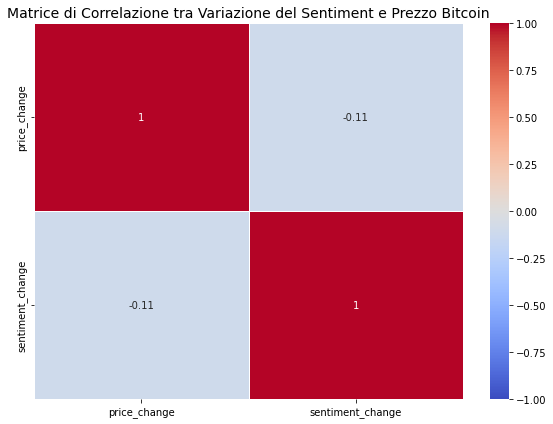

In [0]:

# Matrice di correlazione tra le variazioni del prezzo di Bitcoin e del sentiment
correlation = merged_df[['price_change', 'sentiment_change']].corr()

# Visualizzazione della matrice di correlazione con una heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=0.5)
plt.title("Matrice di Correlazione tra Variazione del Sentiment e Prezzo Bitcoin", fontsize=14)
plt.tight_layout()
plt.show()

**Correlazione tra variazioni di prezzo (price_change_pct) e sentiment (sentiment_change):**

La correlazione è _debole_ (0.11).
Questo suggerisce che le variazioni di prezzo del Bitcoin non sono influenzati dal sentiment dei tweets e viceversa.